In [1]:
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np

# Loading the data

In [67]:
df = pd.Series()
df['sub'] = pd.read_csv('./Data/sub-area.csv',index_col='Time stamp',low_memory=False)
#df['area'] = pd.read_csv('./Data/area.csv',index_col='Time stamp',low_memory=False)
df['sub'].shape

(40726, 8)

In [58]:
df['sub'].head()

,Area,Day,Parking_Category,Peak Hour,Sub_Area,Free_Spaces,Used_Spaces,% full
Time stamp,,,,,,,,
2014-04-08 08:00:00,12th Ave,Weekday,Paid Parking,No,12TH AVE BETWEEN E BARCLAY CT AND E JAMES CT,12.0,0.0,100.0
2014-04-08 08:00:00,12th Ave,Weekday,Paid Parking,No,12TH AVE BETWEEN E CHERRY ST AND E COLUMBIA ST,13.0,7.0,65.0
2014-04-08 08:00:00,12th Ave,Weekday,Paid Parking,No,12TH AVE BETWEEN E COLUMBIA ST AND E MARION ST,15.0,4.0,79.0
2014-04-08 08:00:00,12th Ave,Weekday,Paid Parking,No,12TH AVE BETWEEN E JAMES CT AND E CHERRY ST,4.0,2.0,67.0
2014-04-08 08:00:00,12th Ave,Weekday,Paid Parking,No,12TH AVE BETWEEN E JEFFERSON ST AND E BARCLAY CT,8.0,0.0,100.0


In [59]:
df['area'].head()

,Area,Day,Parking_Category,Peak Hour,Free_Spaces,Used_Spaces,% full
Time stamp,,,,,,,
2014-04-08 08:00:00,12th Ave,Weekday,Paid Parking,No,78.0,22.0,78.0
2014-04-08 09:00:00,12th Ave,Weekday,Paid Parking,No,78.0,44.0,64.0
2014-04-08 10:00:00,12th Ave,Weekday,Paid Parking,No,78.0,48.0,62.0
2014-04-08 11:00:00,12th Ave,Weekday,Paid Parking,No,78.0,46.0,63.0
2014-04-08 12:00:00,12th Ave,Weekday,Paid Parking,No,78.0,51.0,60.0


# Data exploration

The parts which are interesting, is the numeric data. Specifically, parking_spaces and Total Vehicle count is of interest. For non numeric data, the most interesting columns seem to be Subarea Label and Study_area. It could also be usefull to create a new column, indicating wether it is a weekday or a weekend, to research the difference.

## Numeric

For reference, i will investigate the content of Parking_Spaces, as it is not clear what this means.

In [60]:
df['area']['Area'].unique()

Capitol Hill           202
Ballard                196
Pike                   158
Fremont                145
Roosevelt              139
Cherry Hill            128
Pioneer Square         123
South Lake Union       118
First Hill             115
Green Lake             108
Belltown               104
Commercial Core        103
Uptown                  97
Chinatown               85
Denny Triangle          68
Little Saigon           67
University District     55
Uptown Triangle         54
Westlake                52
12th Ave                47
15th Ave                39
Dexter                  39
Columbia City           28
Name: Area, dtype: int64

12th Ave


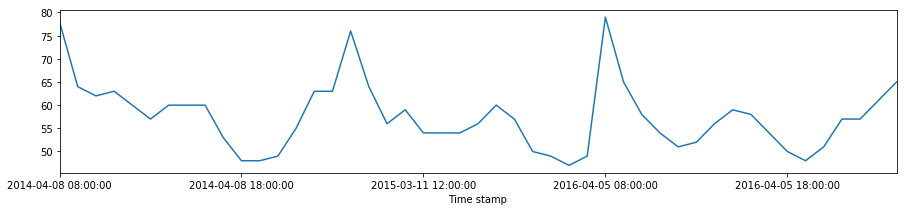

University District


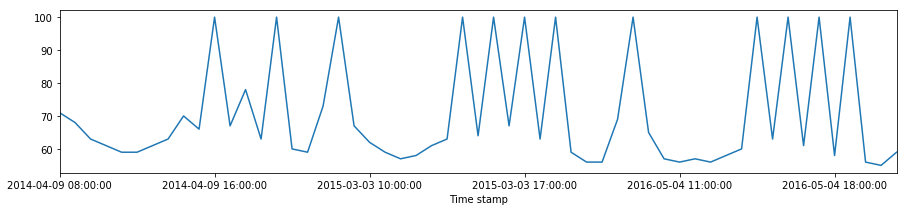

Uptown Triangle


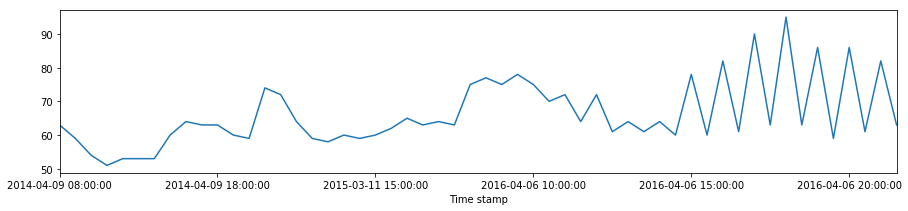

Westlake


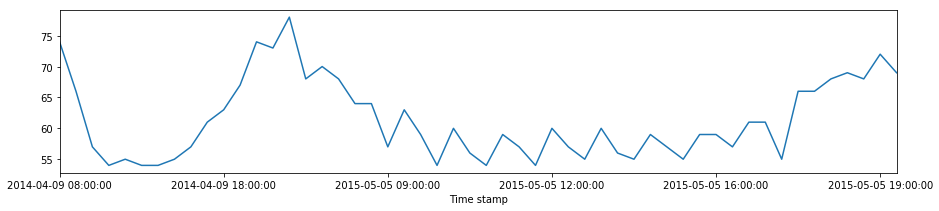

Ballard


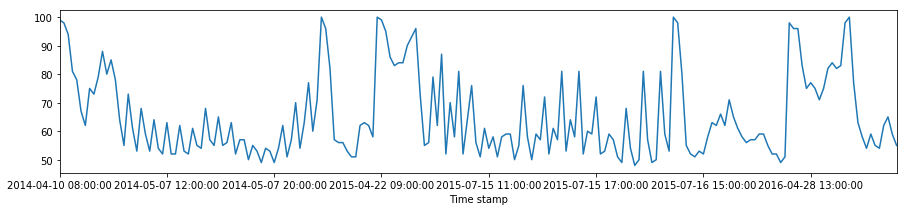

Chinatown


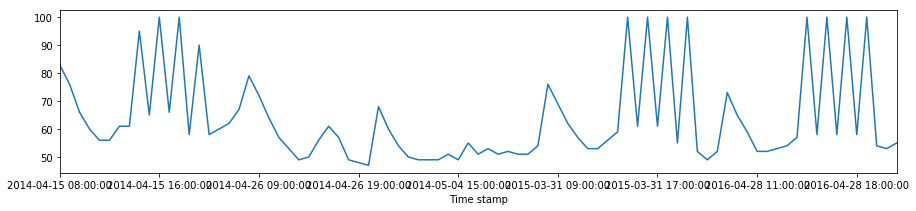

Fremont


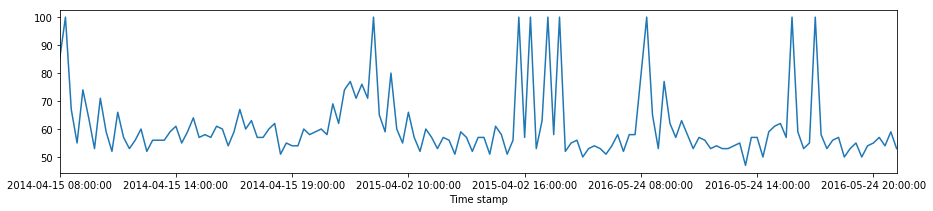

Green Lake


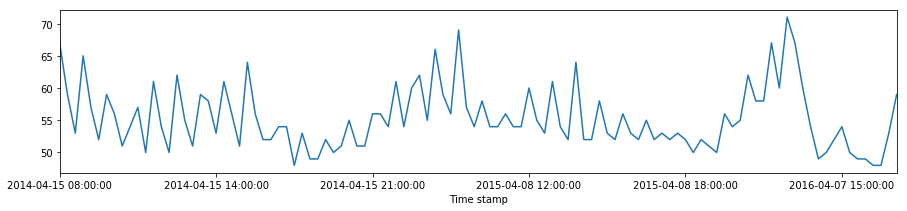

Capitol Hill


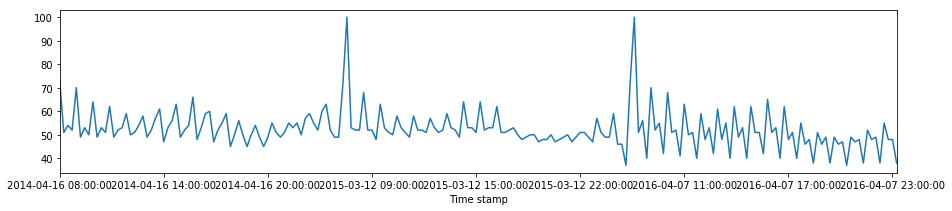

Cherry Hill


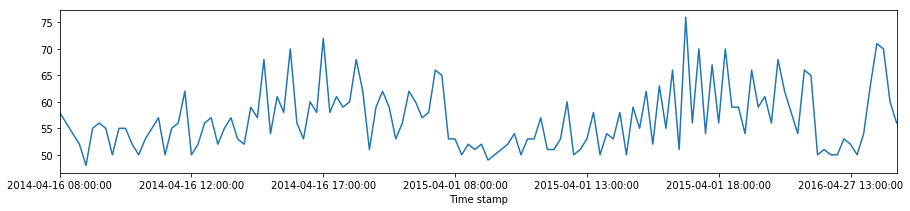

Belltown


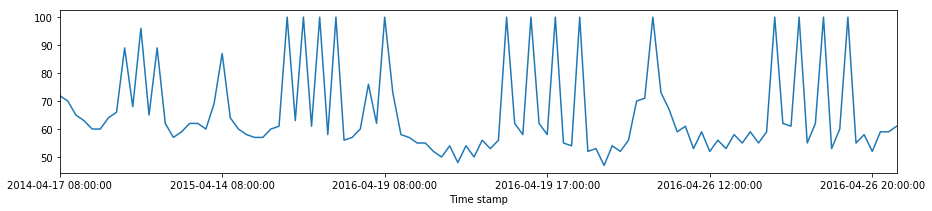

Little Saigon


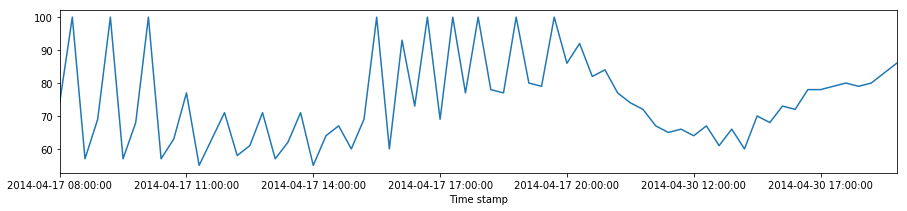

Pioneer Square


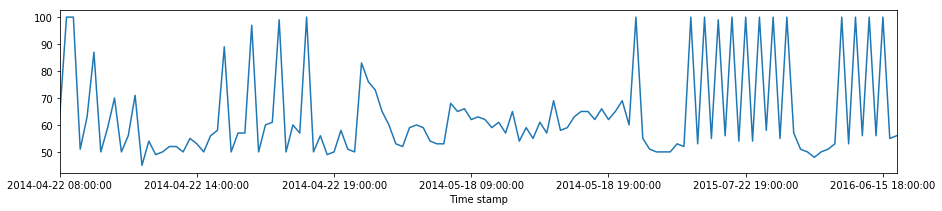

Commercial Core


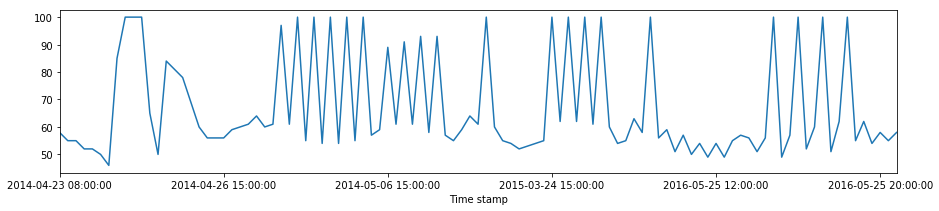

Denny Triangle


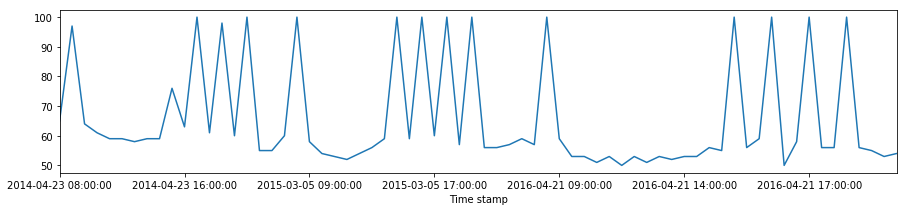

Pike


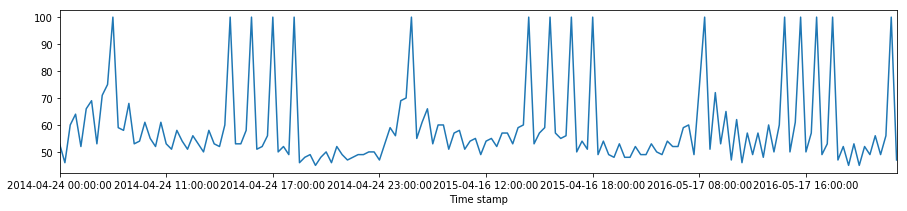

South Lake Union


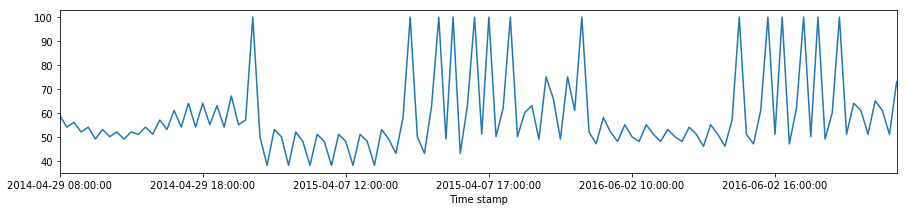

First Hill


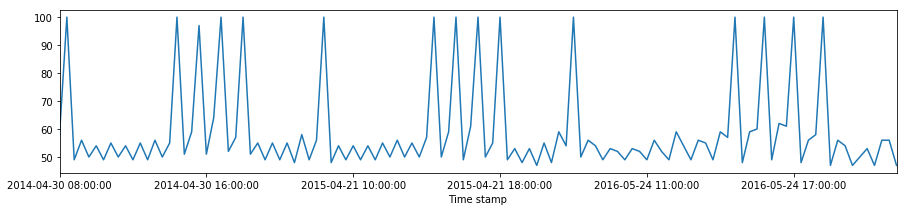

Roosevelt


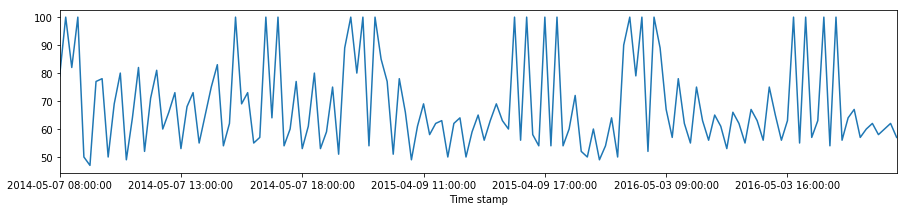

Uptown


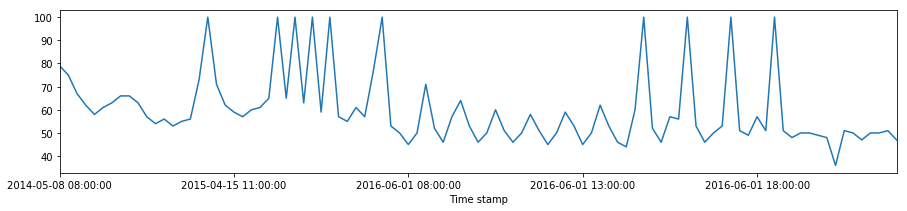

Columbia City


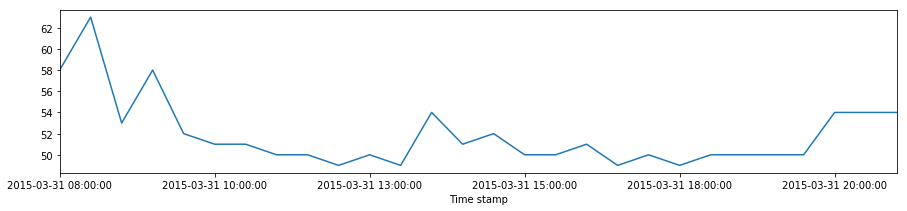

Dexter


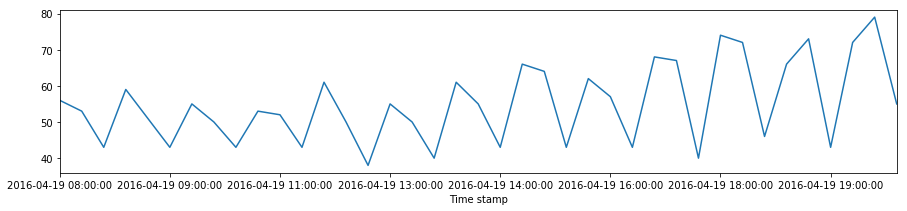

15th Ave


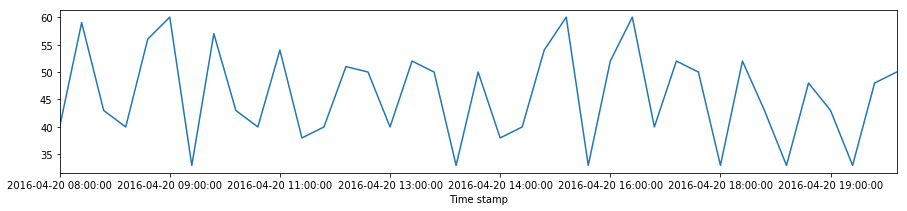

In [64]:
my_list = df['area']['Area'].unique().tolist()

for item in my_list:
    print(item)
    obj = df['area'][df['area']['Area'].isin({item})]
    plt.figure(figsize=(15,3))
    obj['% full'].plot();
    plt.show()

In [22]:
df['raw']['Free_Spaces'].value_counts().head(10)

10.0    2847
8.0     2802
6.0     2261
14.0    2227
12.0    2030
18.0    1944
7.0     1920
16.0    1881
4.0     1808
9.0     1536
Name: Free_Spaces, dtype: int64

Entire dataset


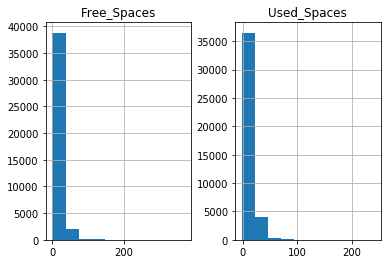

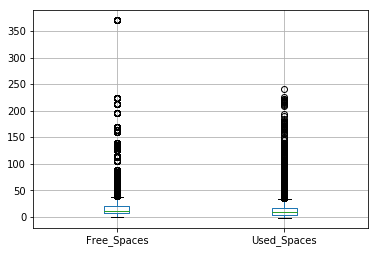

In [23]:
print('Entire dataset')
df['raw'][['Free_Spaces','Used_Spaces']].hist()
plt.show()
df['raw'][['Free_Spaces','Used_Spaces']].boxplot()
plt.show()

Weekdays


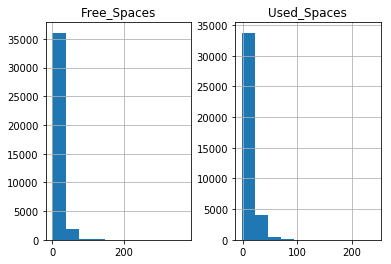

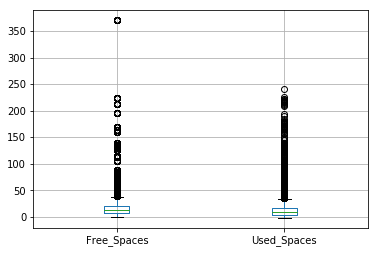

In [24]:
print('Weekdays')
obj = df['raw'][df['raw'].Day.isin({'Weekday'})]
obj[['Free_Spaces','Used_Spaces']].hist()
plt.show()
obj[['Free_Spaces','Used_Spaces']].boxplot()
plt.show()

Weekends


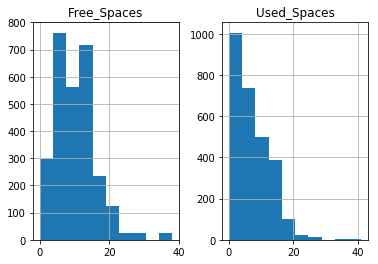

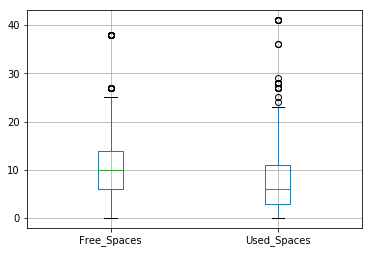

In [25]:
print('Weekends')
obj = df['raw'][df['raw'].Day.isin({'Weekend'})]
obj[['Free_Spaces','Used_Spaces']].hist()
plt.show()
obj[['Free_Spaces','Used_Spaces']].boxplot()
plt.show()

In [9]:
df['raw'][df['raw']['Sub_Area'] == '12TH AVE BETWEEN E BARCLAY CT AND E JAMES CT'].head()

,Time stamp,ID,Area,Sub_Area,Side,Day,Parking_Category,Peak Hour,Free_Spaces,Used_Spaces
6,2014-04-08 08:00:00,46729,12th Ave,12TH AVE BETWEEN E BARCLAY CT AND E JAMES CT,W,Weekday,Paid Parking,No,7.0,0.0
11,2014-04-08 08:00:00,46730,12th Ave,12TH AVE BETWEEN E BARCLAY CT AND E JAMES CT,E,Weekday,Paid Parking,No,5.0,0.0
17,2014-04-08 09:00:00,46730,12th Ave,12TH AVE BETWEEN E BARCLAY CT AND E JAMES CT,E,Weekday,Paid Parking,No,5.0,1.0
20,2014-04-08 09:00:00,46729,12th Ave,12TH AVE BETWEEN E BARCLAY CT AND E JAMES CT,W,Weekday,Paid Parking,No,7.0,0.0
30,2014-04-08 10:00:00,46729,12th Ave,12TH AVE BETWEEN E BARCLAY CT AND E JAMES CT,W,Weekday,Paid Parking,No,7.0,0.0


In [27]:
df['raw'].shape

(41250, 7)

In [28]:
df['raw'][df['raw']['Sub_Area'] == '12TH AVE BETWEEN E CHERRY ST AND E COLUMBIA ST'].tail()

,Area,Day,Parking_Category,Peak Hour,Sub_Area,Free_Spaces,Used_Spaces
Time stamp,,,,,,,
2016-04-05 20:00:00,12th Ave,Weekday,Paid Parking,No,12TH AVE BETWEEN E CHERRY ST AND E COLUMBIA ST,13.0,13.0
2016-04-05 21:00:00,12th Ave,Weekday,Paid Parking,No,12TH AVE BETWEEN E CHERRY ST AND E COLUMBIA ST,13.0,14.0
2016-04-05 22:00:00,12th Ave,Weekday,Paid Parking,No,12TH AVE BETWEEN E CHERRY ST AND E COLUMBIA ST,13.0,12.0
2016-04-05 23:00:00,12th Ave,Weekday,Paid Parking,No,12TH AVE BETWEEN E CHERRY ST AND E COLUMBIA ST,13.0,9.0
2016-04-06 00:00:00,12th Ave,Weekday,Paid Parking,No,12TH AVE BETWEEN E CHERRY ST AND E COLUMBIA ST,13.0,10.0


In [30]:
df['raw']['Area'].unique()

array(['12th Ave', 'University District', 'Uptown Triangle', 'Westlake',
       'Ballard', 'Chinatown', 'Fremont', 'Green Lake', 'Capitol Hill',
       'Cherry Hill', 'Belltown', 'Little Saigon', 'Pioneer Square',
       'Commercial Core', 'Denny Triangle', 'Pike', 'South Lake Union',
       'First Hill', 'Roosevelt', 'Uptown', 'Columbia City', 'Dexter',
       '15th Ave'], dtype=object)